## Calculate non-dimensional numbers for Barkley Canyon fitted profiles (Pathways Cruise)

Scaling the advection-diffusion equation gives the following non dimensional parameters:


| Symbol | Definition | Description | Barkley Canyon estimate |
|:------:|:----------:|:-------------:|:-----------------------:|
|$Pe_h$  | $\frac{LU*}{ \kappa_{I}}$| Horizontal Peclet number | $2.11 \times 10^2 $ |      
|$Pe_v$  | $\frac{Z \Omega}{ \kappa_{D}}$ | Vertical Peclet number | $1.24$ |       
| $K$    | $\frac{Z^2}{L^2}\frac{\kappa_{I}}{\kappa_{D}}$ | Diffusivity ratio |$5.88 \times 10^{-3} $ |
|$\Gamma$| $\frac{Z}{L} \frac{\delta_{v}C}{\delta_{h}C} $ | Gradient ratio | Tracer dependent |
|$\tau_h$|$\frac{ L \delta^2_{h}C}{\Gamma  \delta_{h}C}$  |Horizontal torsion to curvature ratio | Tracer dependent |
|$\tau_v$|$-\frac{Z \delta^2_{v}C}{ \delta_{v}C}$ | Vertical torsion to curvature ratio | Tracer dependent |

In this notebook I calculate the 'tracer dependent values' using data from the Pathways cruise.

*I still need to add DIC and TA data

In [5]:
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from netCDF4 import Dataset

import numpy as np

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import canyon_tools.readout_tools as rout
import canyon_tools.metrics_tools as mpt


In [6]:
def scalingProfiles(L,Z,dvC,dv2C,dhC,dh2C = 0.0):
    '''Calculate all non-dim numbers in the scaling scheme that depend on the profile characteristics.
    
    INPUT (values can be arrays or scalars, as long as they are the same size)
    
    L   : Length of the canyon
    Z   : Depth of upwelling
    dvC : Initial vertical gradient of concentration
    dv2C: Initial vertical second derivative of concentration
    dhC : Initial horizontal gradient of concentration (in the direction of the canyon axis)
    dh2C: Initial horizontal second derivative of concentration (default is 0)
    
    OUTPUT
    
    Tauv,Tauh,Gamma non-dim values as arrays if input values were arrays or scalars.
    
    '''
    
    if dhC == 0:
        Tauv = (Z * dv2C)/(dvC)
        Gamma = (L * dhC) /(Hs * dvC)
        Tauh = np.NaN
        
    else :
        Tauv = (Z * dv2C)/(dvC)
        Gamma = (L * dhC) /(Hs * dvC)
        Tauh = (Gamma *L*dh2C)/dhC
    
    return Tauv,Tauh,Gamma

In [7]:
def scalingDynamics(kd,ki,N,L,Hs,f,Ush,W,R,):
    '''Calculates all non-dim numbers in the scaling scheme related to N.
    
    INPUT (values can be arrays or scalars, as long as they are the same size)
    
    kd : vertical diffusivity
    ki : isopycnal diffusivity
    N  : Brunt-Vaisala frequancy
    L  : Length of the canyon
    Hs : Depth of the shelf-break
    f  : Coriolis parameter
    Ush: Speed upstream of the canyon
    W  : Width of canyon at 1/2 length
    R  : Radius of curvature upstream isobath (\cal{R} in Allen and Hickey 2010)
   
    OUTPUT
    
    Peh,Pev,K non-dim values as arrays if input values were arrays or scalars.
    
    '''
    
    Peh = L*Ustar(f,Ush,L,R,N)/ki
    Pev = Z(f,Ush,L,R,N)*Omega(f,Ush,L,R,N)/kd
    K = ((Z(f,Ush,L,R,N)**2) * ki) / ((L**2) * kd)
    return Pev, Peh, K

In [26]:
def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

def Z(f,U,L,R,N):
    '''Upwelling depth'''
    return((f*U*L*F(Ro(U,f,R)))/(N**2))**(1/2)

def Ustar(f,U,L,R,N): 
    '''Horizontal upwelling speed'''
    return(Z(f,U,L,R,N)**2)/((Dh(f,L,N)**2)*(Ro(U,f,L)**(0.5)))

def Omega(f,U,L,R,N):
    '''Vertical upwelling speed'''
    return(Z(f,U,L,R,N)*Ustar(f,U,L,R,N)/L)

In [11]:
# Fitted profiles for Falkor data

def S1(p):
    '''First 170 m of salinity profile'''
    profile = 1.7782E-2*p +(32.115*np.ones(np.shape(p))) 
    return profile

def dS1dz(p):
    profile = np.ones(np.shape(p))*1.77E-2
    return profile
# ----------------------------------------------------------------------------------------------------------------------
def S2(p):
    '''Under 170 m of salinity profile'''
    profile = 5.8233E-4*p +33.811*np.ones(np.shape(p)) 
    return profile

def dS2dz(p):
    profile = np.ones(np.shape(p))*5.8233E-4
    return profile
# ----------------------------------------------------------------------------------------------------------------------

def O2(p):
    '''0 - 800 m of O2 profile'''
    profile = (2.2111E2*np.exp(-6.3637E-3*p)) + (np.ones(np.shape(p))*18.038)
    return profile

def dO2dz(p):
    return(2.2111E2*(-6.3637E-3)*np.exp(-6.3637E-3*p))

def d2O2dz2(p):
    return(2.2111E2*((-6.3637E-3)**2)*np.exp(-6.3637E-3*p))
# ----------------------------------------------------------------------------------------------------------------------
    
def NO3(p):
    '''0 - 800 m of NO3 profile'''
    profile = 8.2384*np.log(p) - (np.ones(np.shape(p))*8.9536)  
    return profile

def dNO3dz(p):
    return(8.2384/(p))  

def d2NO3dz2(p):
    return(-8.2384/(p**2))  
# ----------------------------------------------------------------------------------------------------------------------
    
def Si(p):
    '''0 - 400 m of Si profiles'''
    profile = 3.763*np.sqrt(p) + (np.ones(np.shape(p))*2.391) #0.09835*p + (np.ones(np.shape(p))*32.3222)
    return profile

def dSidz(p):
    return(3.763/(2*(p**(1/2)) ))

def d2Sidz2(p):
    return(-3.763/(4*(p**(3/2)) ))
# ----------------------------------------------------------------------------------------------------------------------
   
def PO4(p):
    '''0 - 800 m of PO4 profile'''
    profile = p**(0.20431)  
    return profile

def dPO4dz(p):
    return(0.20431*p**(0.20431-1))  

def d2PO4dz2(p):
    return((0.20431)*(0.20431-1)*p**(0.20431-2))  



In [13]:
# Gradients Falkor profiles

dvAvg = np.zeros((7,1))
dv2Avg = np.zeros((7,1))

p1 = np.arange(0,110,10) 
p2 = np.arange(110,400,10)
p3 = np.arange(0,400,10) 

O2prof = O2(p3)
dvO2 = dO2dz(p3)
dvAvg[1] = np.mean(dvO2[10:25])
dv2O2 = d2O2dz2(p3)
dv2Avg[1] = np.mean(dv2O2[10:25])

NO3prof = NO3(p3)
dvNO3 = dNO3dz(p3)
dvAvg[2]= np.mean(dvNO3[10:25])
dv2NO3 = d2NO3dz2(p3)
dv2Avg[2] = np.mean(dv2NO3[10:25])

PO4prof = PO4(p3)
dvPO4 = dPO4dz(p3)
dvAvg[3] = np.mean(dvPO4[10:25])
dv2PO4 = d2PO4dz2(p3)
dv2Avg[3] = np.mean(dv2PO4[10:25])

Siprof = Si(p3)
dvSi = dSidz(p3)
dvAvg[4] = np.mean(dvSi[10:25])
dv2Si = d2Sidz2(p3)
dv2Avg[4] = np.mean(dv2Si[10:25])



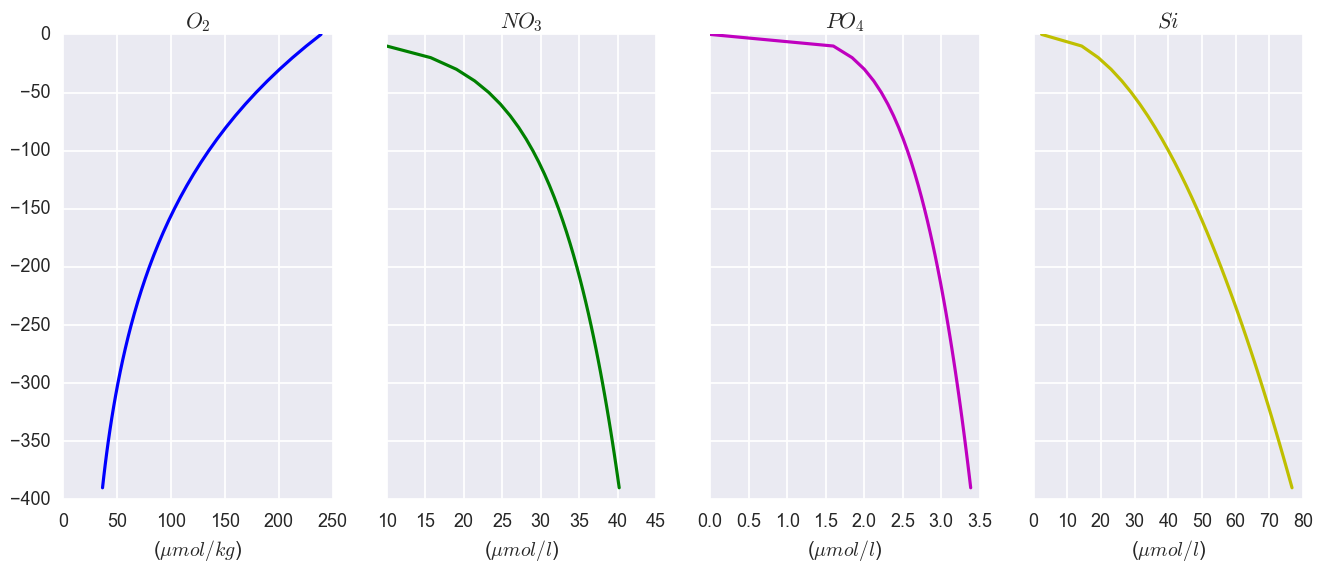

In [14]:
sns.set_context('talk')
fig, (ax2,ax3,ax4,ax5) = plt.subplots(1, 4,figsize=(16, 6), sharey=True)

ax2.plot(O2prof,-p3,'b')
ax2.set_title('$O_2$')
ax2.set_xlabel('($\mu mol/kg$)')

ax3.plot(NO3prof,-p3,'g')
ax3.set_title('$NO_3$')
ax3.set_xlabel('($\mu mol/l$)')

ax4.plot(PO4prof,-p3,'m')
ax4.set_title('$PO_4$')
ax4.set_xlabel('($\mu mol/l$)')

ax5.plot(Siprof,-p3,'y')
ax5.set_title('$Si$')
ax5.set_xlabel('($\mu mol/l$)')


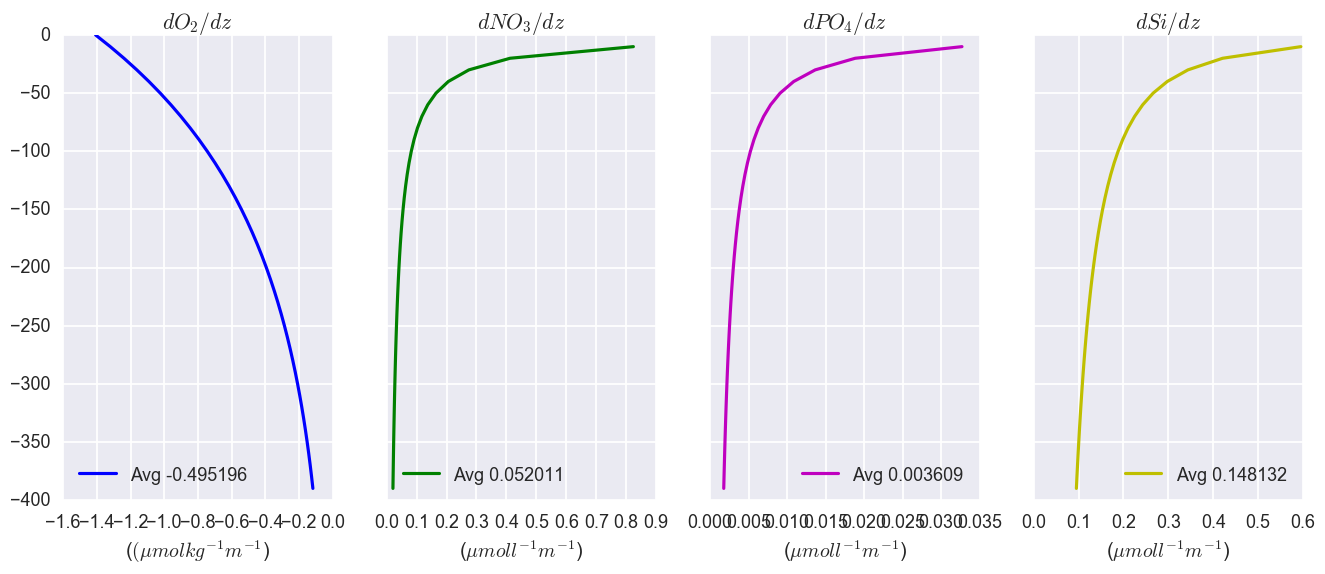

In [16]:
sns.set_context('talk')
fig, (ax2,ax3,ax4,ax5) = plt.subplots(1, 4,figsize=(16, 6), sharey=True)

ax2.plot(dvO2,-p3[:],'b',label = ('Avg %f' %dvAvg[1]))
ax2.set_title('$dO_2/dz$')
ax2.set_xlabel('($(\mu mol kg^{-1} m^{-1}$)')
ax2.legend(loc = 0)

ax3.plot(dvNO3,-p3[:],'g',label = ('Avg %f' %dvAvg[2]))
ax3.set_title('$dNO_3/dz$')
ax3.set_xlabel('($\mu mol l^{-1} m^{-1}$)')
ax3.legend(loc = 0)

ax4.plot(dvPO4,-p3[:],'m',label = ('Avg %f' %dvAvg[3]))
ax4.set_title('$dPO_4/dz$')
ax4.set_xlabel('($\mu mol l^{-1} m^{-1}$)')
ax4.legend(loc = 0)

ax5.plot(dvSi,-p3[:],'y',label = ('Avg %f' %dvAvg[4]))
ax5.set_title('$dSi/dz$')
ax5.set_xlabel('($\mu mol l^{-1} m^{-1}$)')
ax5.legend(loc = 0)

# OJO: average dC/dz from 100 m to 250 m (below mixed layer and above upwelling depth)


In [17]:
# Methane and nitrous acid - see notebook NutrientProfilesLineC2013.ipynb in /Data

#Methane
dvAvg[5] = np.mean([0.04662,0.06764])  #[conc]/m.  May and sep average 2013, so that it matches year of Pathways cruise
dv2Avg[5] = np.mean([-0.00387,-0.00778])

# Nitrous Acid
dvAvg[6] = np.mean([0.05230, 0.03289])
dv2Avg[6] = np.mean([-0.00477,-0.00911])


In [18]:
print(dvAvg)
print(dv2Avg)

[[ 0.        ]
 [-0.49519618]
 [ 0.05201121]
 [ 0.00360891]
 [ 0.14813249]
 [ 0.05713   ]
 [ 0.042595  ]]
[[  0.00000000e+00]
 [  3.15127994e-03]
 [ -3.53458514e-04]
 [ -1.92245010e-05]
 [ -4.85152020e-04]
 [ -5.82500000e-03]
 [ -6.94000000e-03]]


In [20]:
L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
W = 8300 # mid-length width

kd = 3.9E-3
ki = 2.
N = 5.E-3
Hs = 200.0
f = 1.08E-4
Ush = 0.1
dhC = 0 # Change this later

[Pev, Peh, K] = scalingDynamics(kd,ki,N,L,Hs,f,Ush,W,R)
[Tauv,Tauh,Gamma] = scalingProfiles(L,Z(f, Ush, L, R, N),dvAvg,dv2Avg,dhC,dh2C = 0.0)


In [30]:
ii = 0
tracers = ['O2', 'NO3', 'Si', 'PO4']
for trac in tracers:
    
    print(r'$Pe_v$ %s , $Pe_h$ %s, $K$ %s, $\tau_v$ %s, $\tau_h$ %s, $\Gamma$ %s \n' 
          %(Pev, Peh, K, Tauv,Tauh,Gamma))
    ii = ii+1

$Pe_v$ 1.3533766264207726e+16 , $Pe_h$ 21814678252.686466, $K$ 620397.2438851374, $\tau_v$ [[            nan]
 [ -1416.58261409]
 [ -1512.77271907]
 [ -1185.79960432]
 [  -729.05406337]
 [-22696.7626045 ]
 [-36268.78921113]], $\tau_h$ nan, $\Gamma$ [[ nan]
 [ -0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]] \n
$Pe_v$ 1.3533766264207726e+16 , $Pe_h$ 21814678252.686466, $K$ 620397.2438851374, $\tau_v$ [[            nan]
 [ -1416.58261409]
 [ -1512.77271907]
 [ -1185.79960432]
 [  -729.05406337]
 [-22696.7626045 ]
 [-36268.78921113]], $\tau_h$ nan, $\Gamma$ [[ nan]
 [ -0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]] \n
$Pe_v$ 1.3533766264207726e+16 , $Pe_h$ 21814678252.686466, $K$ 620397.2438851374, $\tau_v$ [[            nan]
 [ -1416.58261409]
 [ -1512.77271907]
 [ -1185.79960432]
 [  -729.05406337]
 [-22696.7626045 ]
 [-36268.78921113]], $\tau_h$ nan, $\Gamma$ [[ nan]
 [ -0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]] \n
$Pe_v$ 1.3533766264207726e+16 , $Pe_h$ 21814678252.686466, $K$ 620397.243

Tauv

In [29]:
print(Z(f, Ush, L, R, N))

21.72116188697411


In [31]:
Ustar(f,Ush,L,R,N)

0.0649083425181511